## Fakultät für Physik und Erdsystemwissenschaften
## Module: Sampling Design & Ground Truthing in Remote Sensing
## Report: UAV Processing - Group LAADS
### Submitted by:
    Chinthaparthy Deepak reddy,
    Roohullah Amin,
    Muhammad Abdul wasay khalid,
    Sebastian Löblein,
    Luise Krause
## Date of Submission: 29.07.2024

## 1. Packages
First we load all packages which we will need for our analysis.

In [ ]:
install.packages("ggplot2")
install.packages("terra")
install.packages("raster")
install.packages("sf")
install.packages("ggplot2")
install.packages("gridExtra")
install.packages("rcartocolor")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘sp’




In [53]:
library(terra)
library(sf)
library(raster)
library(ggplot2)
library(gridExtra)
library(rcartocolor)

## 2. UAV Data
### 2.1 Read and Process UAV Data

In [59]:
# Load the UAV DSM (Digital Surface Model)
h_uav_dsm <- raster("uav/cloudcompare_dsm_v2.tif")
# h_uav_dsm <- raster("uav/DJI_202305311408_001_crane_dem.tif")

# Assign the projection to the UAV DSM
crs(h_uav_dsm) <- CRS("+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs")
#h_uav_dsm <- raster("uav/DJI_202305311408_001_crane_dem.tif")

In [60]:
# Some information on the dsm
print(h_uav_dsm)

class      : RasterLayer 
dimensions : 826, 472, 389872  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : 312589, 312825, 5693764, 5694178  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : cloudcompare_dsm_v2.tif 
names      : cloudcompare_dsm_v2 
values     : 142.8009, 190.7211  (min, max)



In [61]:
# set 0 to NA
h_uav_dsm <- reclassify(h_uav_dsm, cbind(0, NA))
print(h_uav_dsm)

class      : RasterLayer 
dimensions : 826, 472, 389872  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : 312589, 312825, 5693764, 5694178  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : cloudcompare_dsm_v2 
values     : 142.8009, 190.7211  (min, max)



### Calculate the normalized DSM (nDSM)
Since we assume a relatively constant terrain height within the area, we can normalize the DSM by subtracting the minimum value. This process results in a normalized DSM (nDSM).

In [62]:
# Calculate the actual minimum value in the UAV DSM data
min_uav_height_actual <- cellStats(h_uav_dsm, stat = 'min', na.rm = TRUE)
# min_uav_height = 147 # actual value is 142.8009
print(paste("The actual minimum UAV height would be:", min_uav_height_actual))

# Calculate the normalized DSM (nDSM)
h_uav_top <- h_uav_dsm - min_uav_height_actual

[1] "The actual minimum UAV height would be: 142.800857543945"


### As we can see now, that height distribution is between 0 and 48 meters

In [63]:
print(h_uav_top)

class      : RasterLayer 
dimensions : 826, 472, 389872  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : 312589, 312825, 5693764, 5694178  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : cloudcompare_dsm_v2 
values     : 0, 47.92027  (min, max)



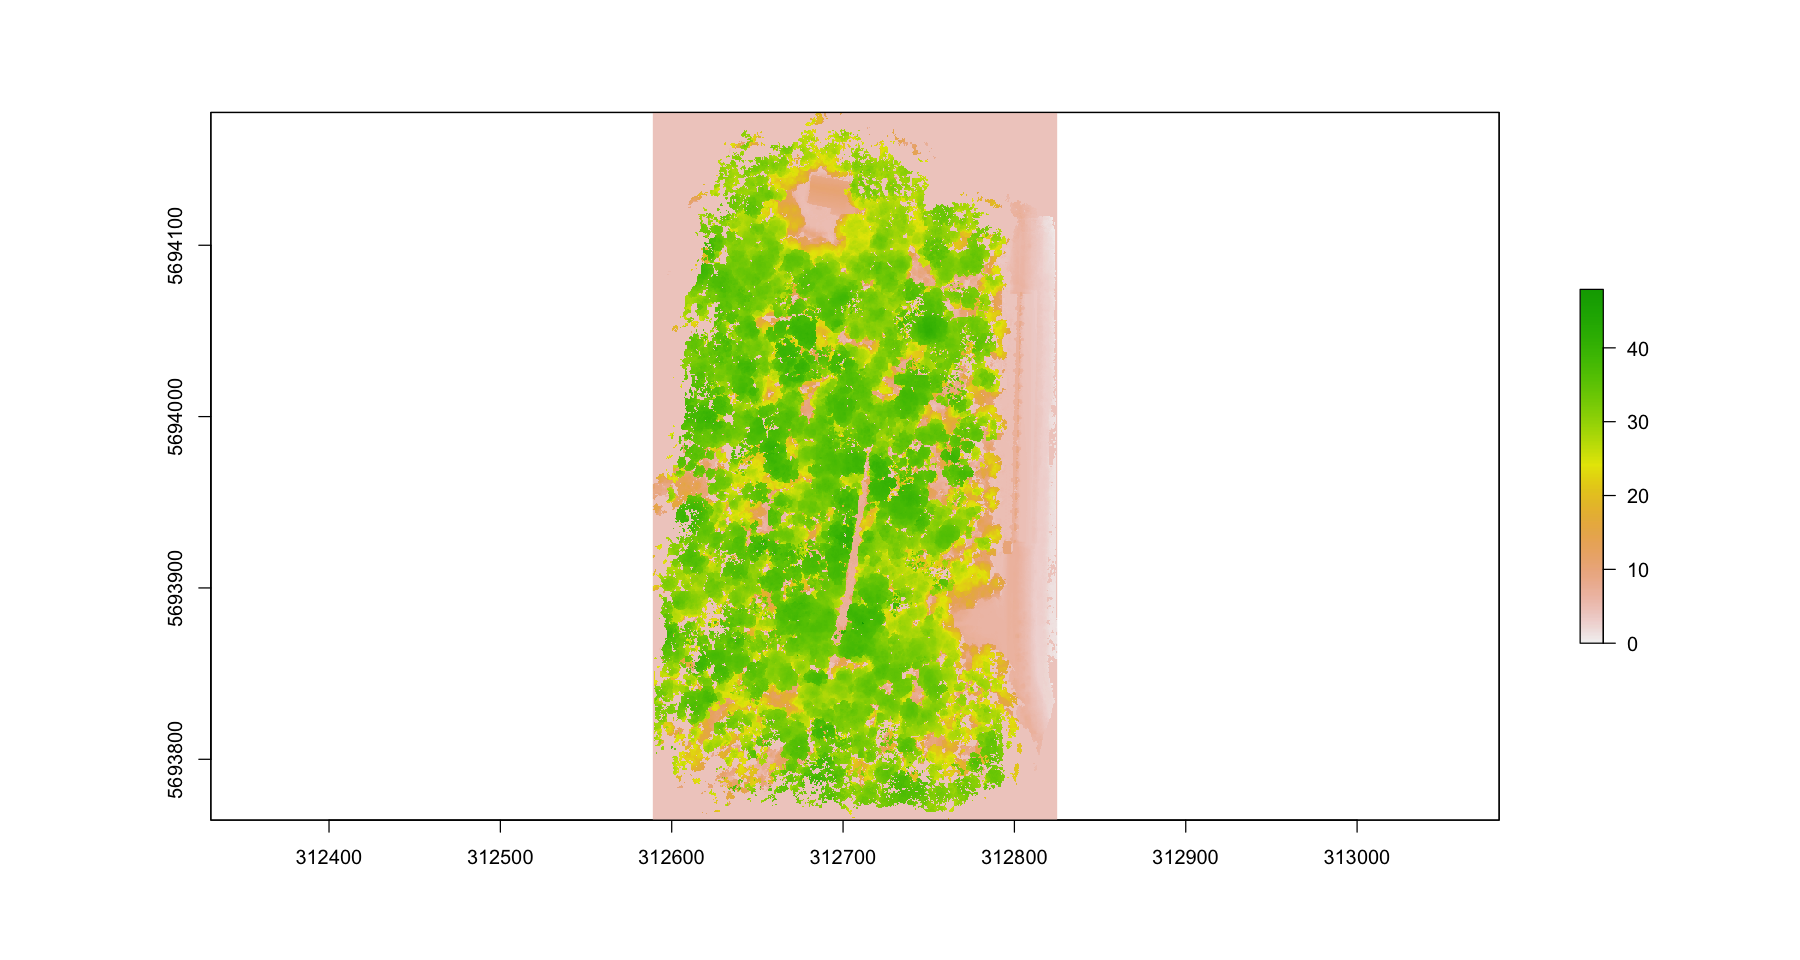

In [64]:
plot(h_uav_top)

In [65]:
# Calculate standard deviation per ~25m² pixels
h_uav_sd = aggregate(h_uav_top, fact = 10, fun = "sd")
h_uav_sd

class      : RasterLayer 
dimensions : 83, 48, 3984  (nrow, ncol, ncell)
resolution : 5, 5  (x, y)
extent     : 312589, 312829, 5693762, 5694178  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : cloudcompare_dsm_v2 
values     : 0, 17.01788  (min, max)


## 3. Reprojection
### Import Sentinel data

In [66]:
h_s2_top <- raster("sentinel/ETH_GlobalCanopyHeight_DE_CHM_clip.tif")
h_s2_sd <- raster("sentinel/ETH_GlobalCanopyHeight_DE_STD_clip.tif")

In [41]:
print(h_s2_sd)

class      : RasterLayer 
dimensions : 509, 702, 357318  (nrow, ncol, ncell)
resolution : 0.000107, 6.69e-05  (x, y)
extent     : 12.27874, 12.35385, 51.34784, 51.3819  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : ETH_GlobalCanopyHeight_DE_STD_clip.tif 
names      : ETH_GlobalCanopyHeight_DE_STD_clip 
values     : -0.2832173, 25  (min, max)



In [42]:
print(h_s2_top)

class      : RasterLayer 
dimensions : 509, 702, 357318  (nrow, ncol, ncell)
resolution : 0.000107, 6.69e-05  (x, y)
extent     : 12.27874, 12.35385, 51.34784, 51.3819  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : ETH_GlobalCanopyHeight_DE_CHM_clip.tif 
names      : ETH_GlobalCanopyHeight_DE_CHM_clip 
values     : -2.137504, 35  (min, max)



### Resample the nDSM to Match the Sentinel Data, and Crop and Mask the Data to the Area of Interest
To compare the UAV-based height data with the Sentinel data, we need to ensure that they are in the same coordinate system, have the same resolution, and cover the same area of interest. The following code accomplishes this:

In [67]:
h_s2_top1 <- projectRaster(h_s2_top,h_uav_top, alignOnly = FALSE)
h_s2_sd1 <- projectRaster( h_s2_sd,h_uav_sd, alignOnly = FALSE)


In [68]:
h_s2_top_res <- resample( h_s2_top1,h_uav_top, method = "bilinear")
h_s2_sd_res <- resample( h_s2_sd1, h_uav_sd,method = "bilinear")

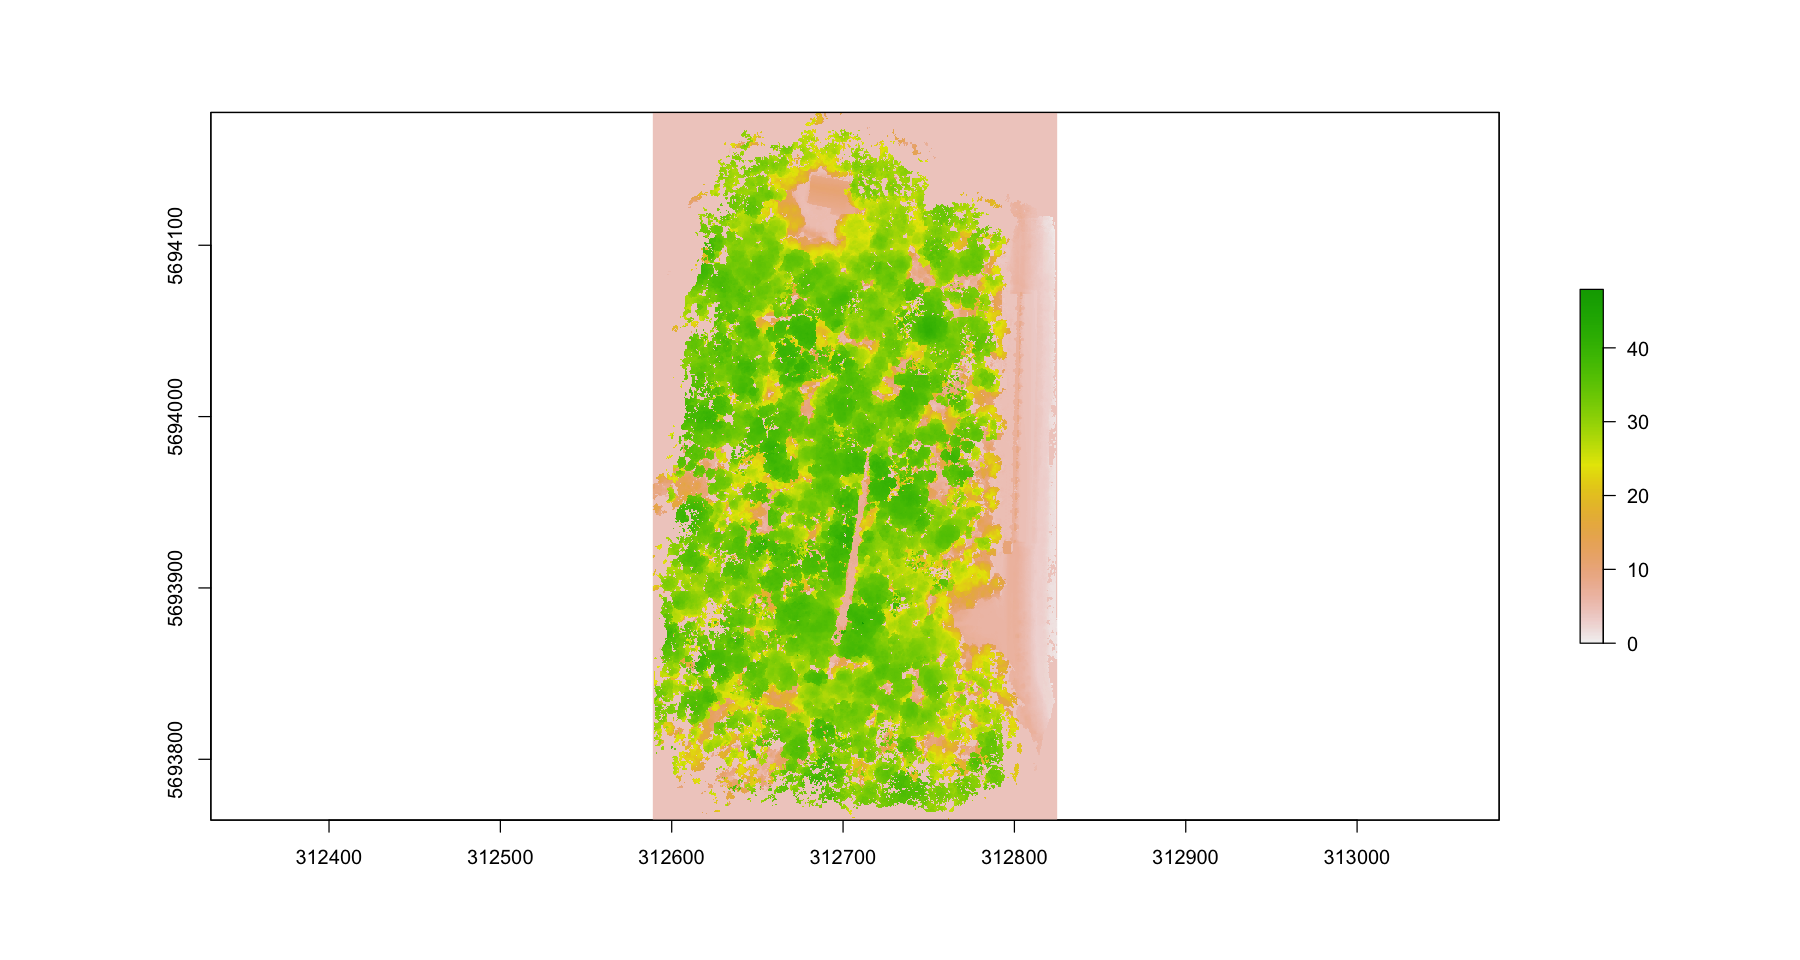

In [69]:
plot(h_uav_top)

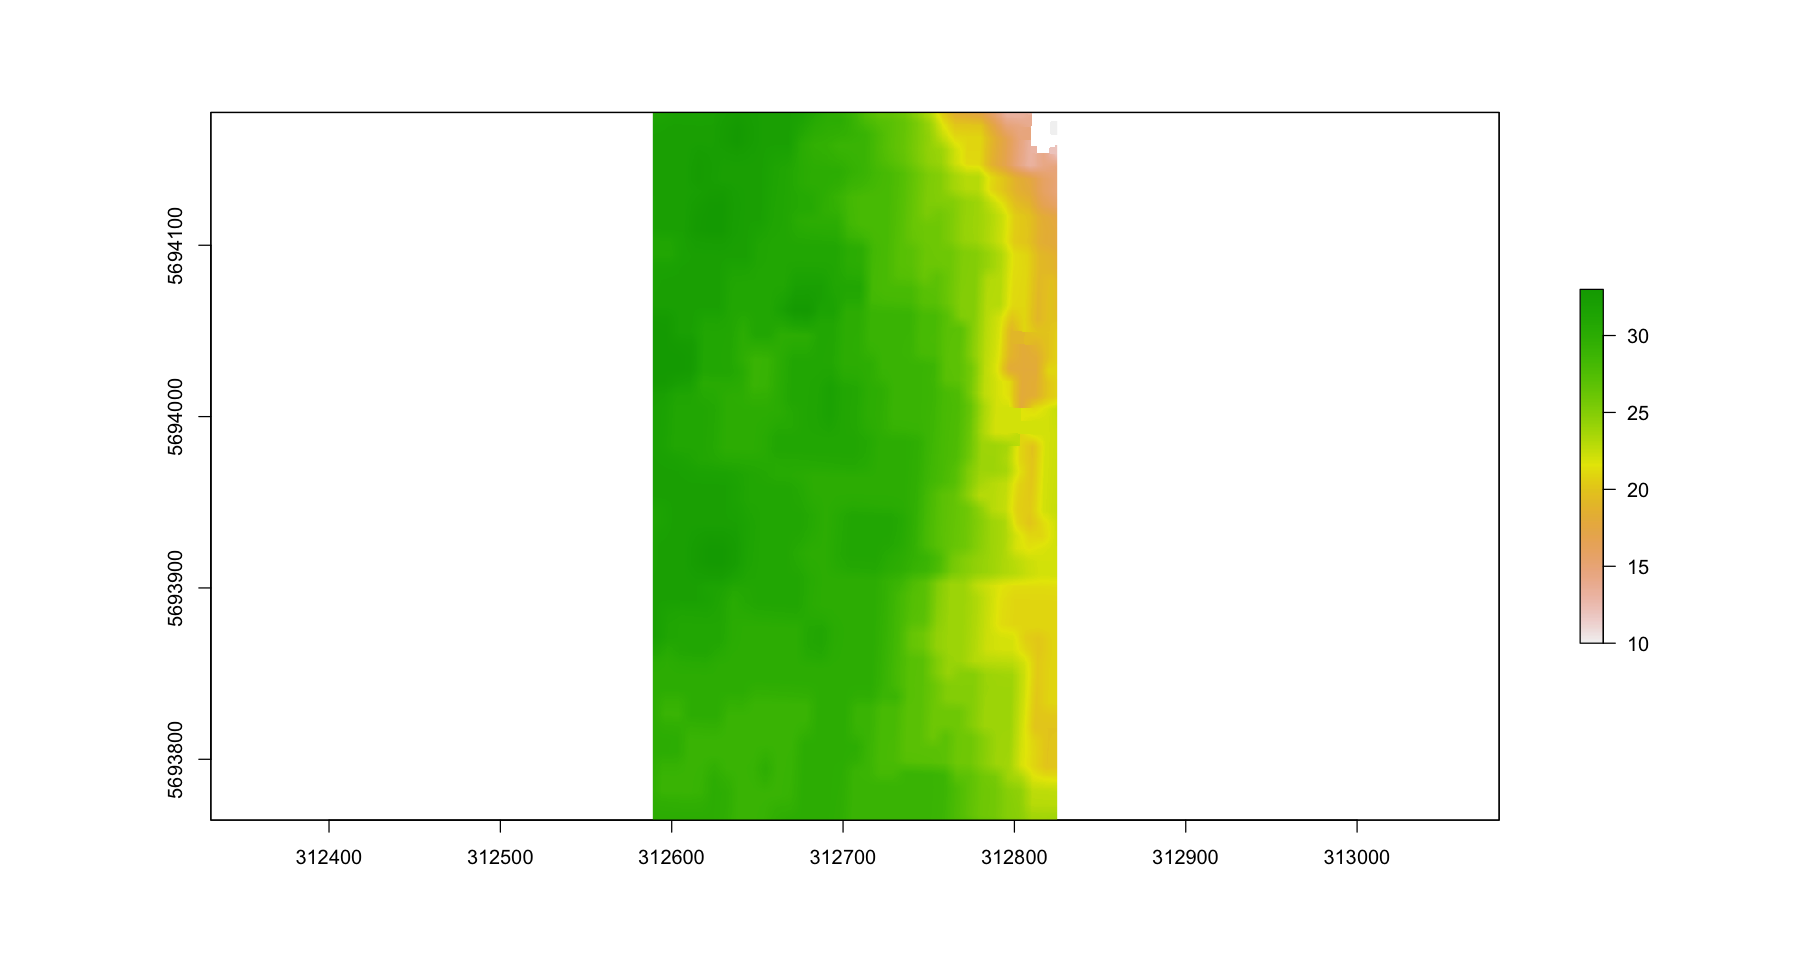

In [70]:
plot(h_s2_top_res)

In [28]:
h_s2_top_res

class      : RasterLayer 
dimensions : 826, 472, 389872  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : 312589, 312825, 5693764, 5694178  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : ETH_GlobalCanopyHeight_DE_CHM_clip 
values     : 10, 33  (min, max)


In [71]:
h_uav_top

class      : RasterLayer 
dimensions : 826, 472, 389872  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : 312589, 312825, 5693764, 5694178  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : cloudcompare_dsm_v2 
values     : 0, 47.92027  (min, max)


### Crop and Mask Data to the Area of Interest
To ensure that our analysis is focused only on the relevant geographical area, we need to crop and mask both the UAV and Sentinel datasets using a shapefile that defines our area of interest (AOI). This process will exclude any data outside the AOI, improving the accuracy and relevance of our comparisons.

###  the shapefile (We  used the one from TLS)



In [72]:
# Read the shapefile
# aoi <- shapefile("aoi_uav_to_s2.shp")
aoi_utm <- shapefile("uav/TLS_area.shp")
target_crs <- CRS("+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs")

aoi <- sp::spTransform(aoi_utm, target_crs)


# Set the CRS
# crs(aoi) <- CRS("+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs")

# Mask the UAV and Sentinel data to the AOI
h_uav_top_res <- mask(h_uav_top, aoi)
h_uav_sd_res <- mask(h_uav_sd, aoi)
h_s2_top <- mask(h_s2_top_res, aoi)
h_s2_sd <- mask(h_s2_sd_res, aoi)

# Crop the UAV and Sentinel data to the AOI
# Cropping removes values outside the AOI, reducing the dataset size
h_uav_top_res <- crop(h_uav_top_res, aoi)
h_uav_sd_res <- crop(h_uav_sd_res, aoi)
h_s2_top <- crop(h_s2_top_res, aoi)
h_s2_sd <- crop(h_s2_sd_res, aoi)


In [73]:
h_uav_top_res

class      : RasterLayer 
dimensions : 141, 116, 16356  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : 312682.5, 312740.5, 5693890, 5693961  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : cloudcompare_dsm_v2 
values     : 4.199142, 41.74994  (min, max)


In [74]:
h_s2_top

class      : RasterLayer 
dimensions : 141, 116, 16356  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : 312682.5, 312740.5, 5693890, 5693961  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : ETH_GlobalCanopyHeight_DE_CHM_clip 
values     : 27.31782, 31  (min, max)


### 4. Compare UAV and Sentinel data

In [75]:
# Calculate residuals
residuals_top <- values(h_s2_top) - values(h_uav_top_res)
residuals_sd <-  values(h_s2_sd) - values(h_uav_sd_res)

# Create data frames for ggplot2
data_top <- data.frame(
  UAV = values(h_uav_top_res),
  Sentinel = values(h_s2_top),
  Residuals = residuals_top
)

data_sd <- data.frame(
  UAV = values(h_uav_sd_res),
  Sentinel = values(h_s2_sd),
  Residuals = residuals_sd
)

# Remove NA values
data_top <- na.omit(data_top)
data_sd <- na.omit(data_sd)


### Histograms

In [76]:
options(repr.plot.width=15, repr.plot.height=8)

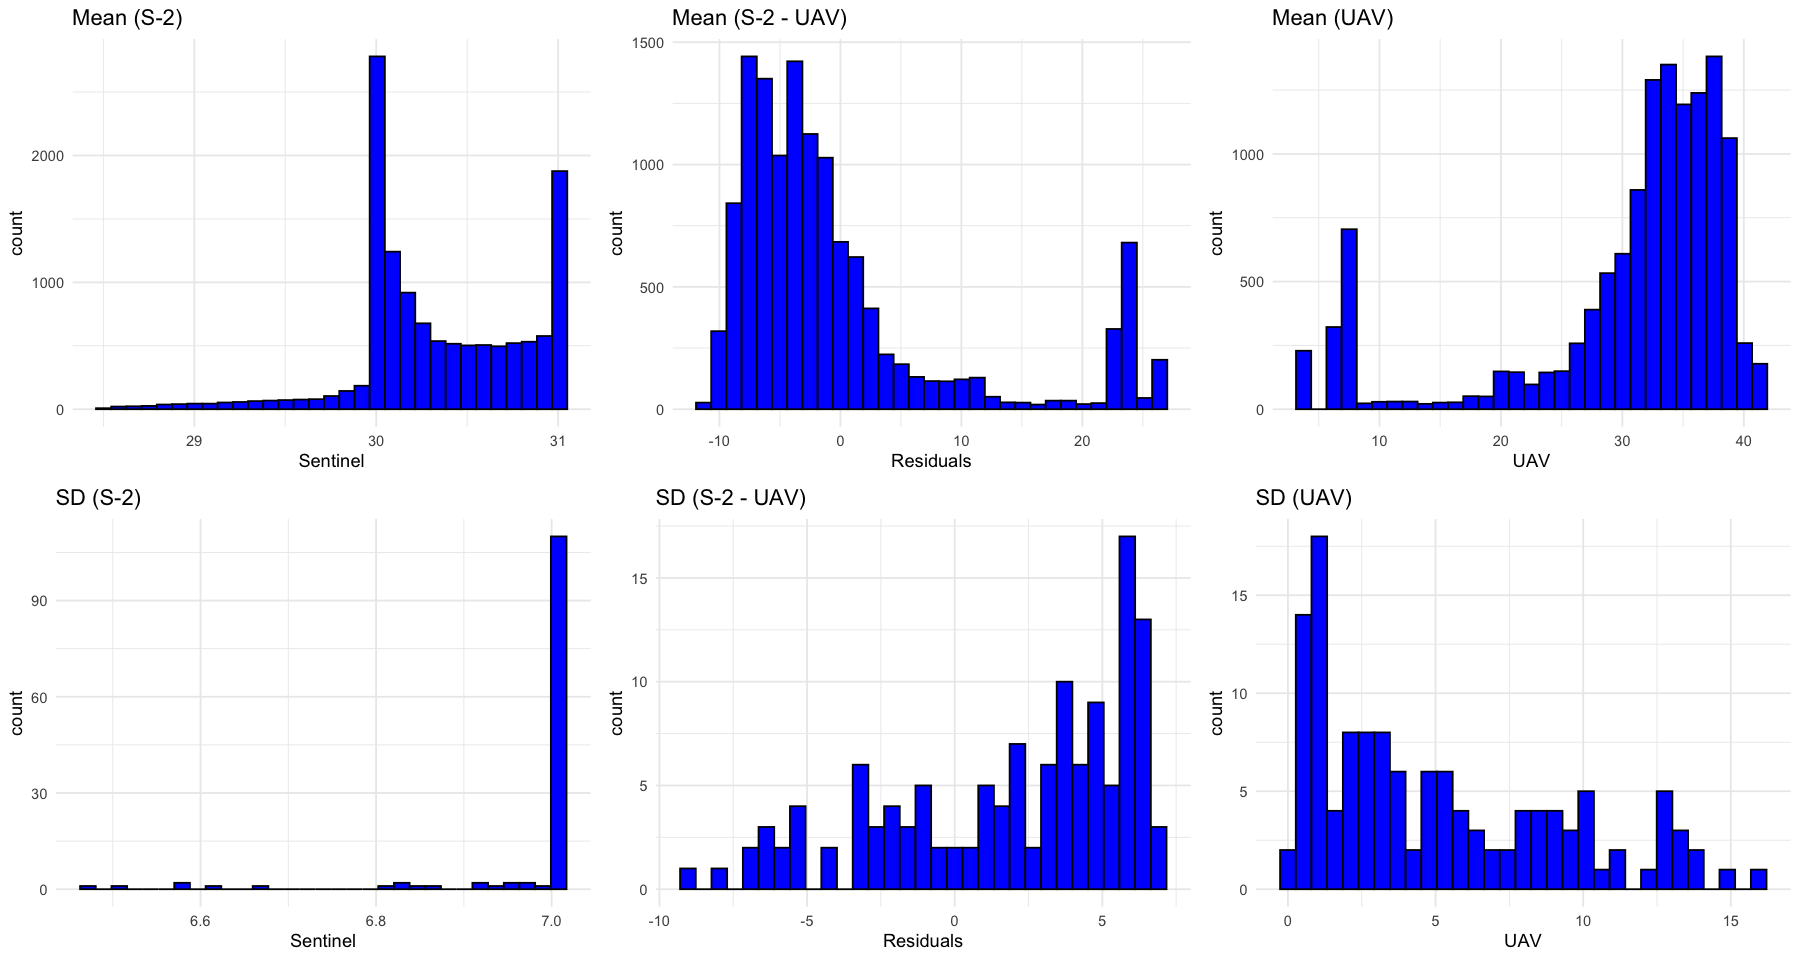

In [77]:
# Calculate appropriate binwidth based on data range
calculate_binwidth <- function(data) {
  range <- max(data, na.rm = TRUE) - min(data, na.rm = TRUE)
  binwidth <- range / 30  # Choose a divisor to set the number of bins (e.g., 30 bins)
  return(binwidth)
}

# Plot histograms for mean (Top)
p1 <- ggplot(data_top, aes(x = Sentinel)) +
  geom_histogram(binwidth = calculate_binwidth(data_top$Sentinel), fill = "blue", color = "black") +
  ggtitle("Mean (S-2)") +
  theme_minimal()

p2 <- ggplot(data_top, aes(x = Residuals)) +
  geom_histogram(binwidth = calculate_binwidth(data_top$Residuals), fill = "blue", color = "black") +
  ggtitle("Mean (S-2 - UAV)") +
  theme_minimal()

p3 <- ggplot(data_top, aes(x = UAV)) +
  geom_histogram(binwidth = calculate_binwidth(data_top$UAV), fill = "blue", color = "black") +
  ggtitle("Mean (UAV)") +
  theme_minimal()

# Plot histograms for SD
p4 <- ggplot(data_sd, aes(x = Sentinel)) +
  geom_histogram(binwidth = calculate_binwidth(data_sd$Sentinel), fill = "blue", color = "black") +
  ggtitle("SD (S-2)") +
  theme_minimal()

p5 <- ggplot(data_sd, aes(x = Residuals)) +
  geom_histogram(binwidth = calculate_binwidth(data_sd$Residuals), fill = "blue", color = "black") +
  ggtitle("SD (S-2 - UAV)") +
  theme_minimal()

p6 <- ggplot(data_sd, aes(x = UAV)) +
  geom_histogram(binwidth = calculate_binwidth(data_sd$UAV), fill = "blue", color = "black") +
  ggtitle("SD (UAV)") +
  theme_minimal()

# Arrange the plots in a grid
grid.arrange(p1, p2, p3, p4, p5, p6, ncol = 3)


### Scatterplots

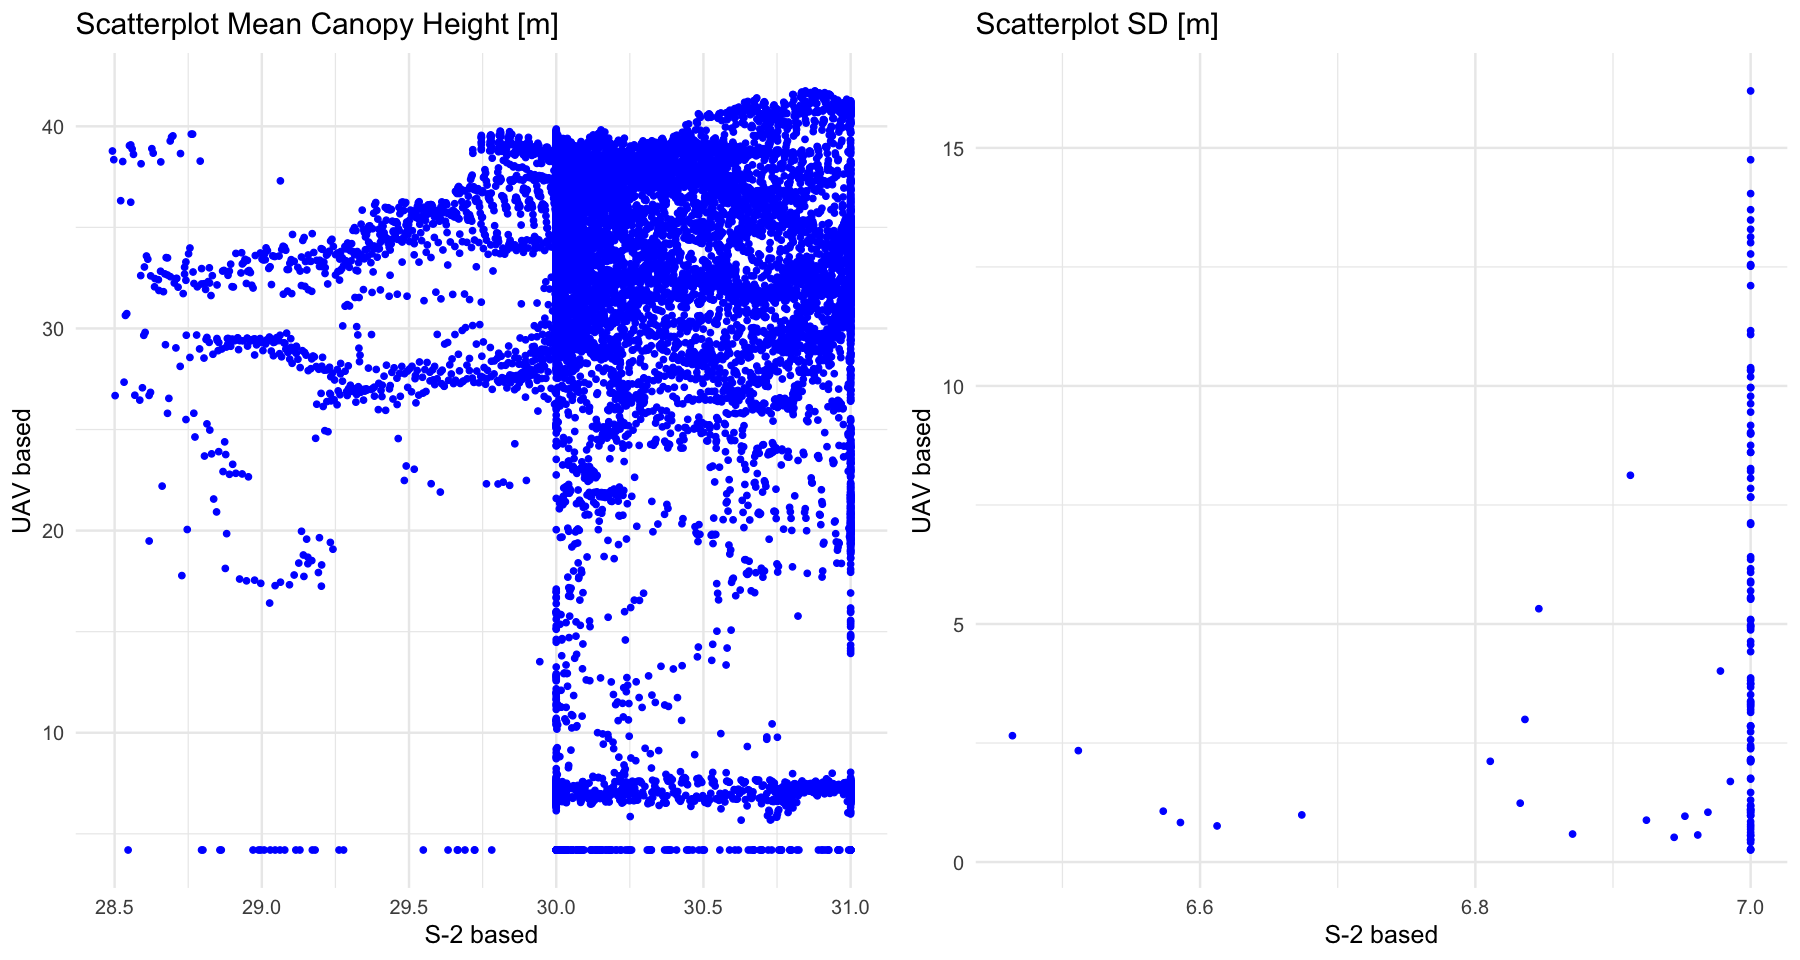

In [78]:
# Scatter plot for Mean Canopy Height
p1 <- ggplot(data_top, aes(x = Sentinel, y = UAV)) +
  geom_point(color = "blue") +
  ggtitle("Scatterplot Mean Canopy Height [m]") +
  xlab("S-2 based") +
  ylab("UAV based") +
  theme_minimal(base_size = 15)

# Scatter plot for Standard Deviation
p2 <- ggplot(data_sd, aes(x = Sentinel, y = UAV)) +
  geom_point(color = "blue") +
  ggtitle("Scatterplot SD [m]") +
  xlab("S-2 based") +
  ylab("UAV based") +
  theme_minimal(base_size = 15)

# Arrange the plots side by side
grid.arrange(p1, p2, ncol = 2)


## Maps

Warning message in plot.window(...):
“"legend.width" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"legend.width" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"legend.width" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"legend.width" is not a graphical parameter”
Warning message in box(...):
“"legend.width" is not a graphical parameter”
Warning message in title(...):
“"legend.width" is not a graphical parameter”


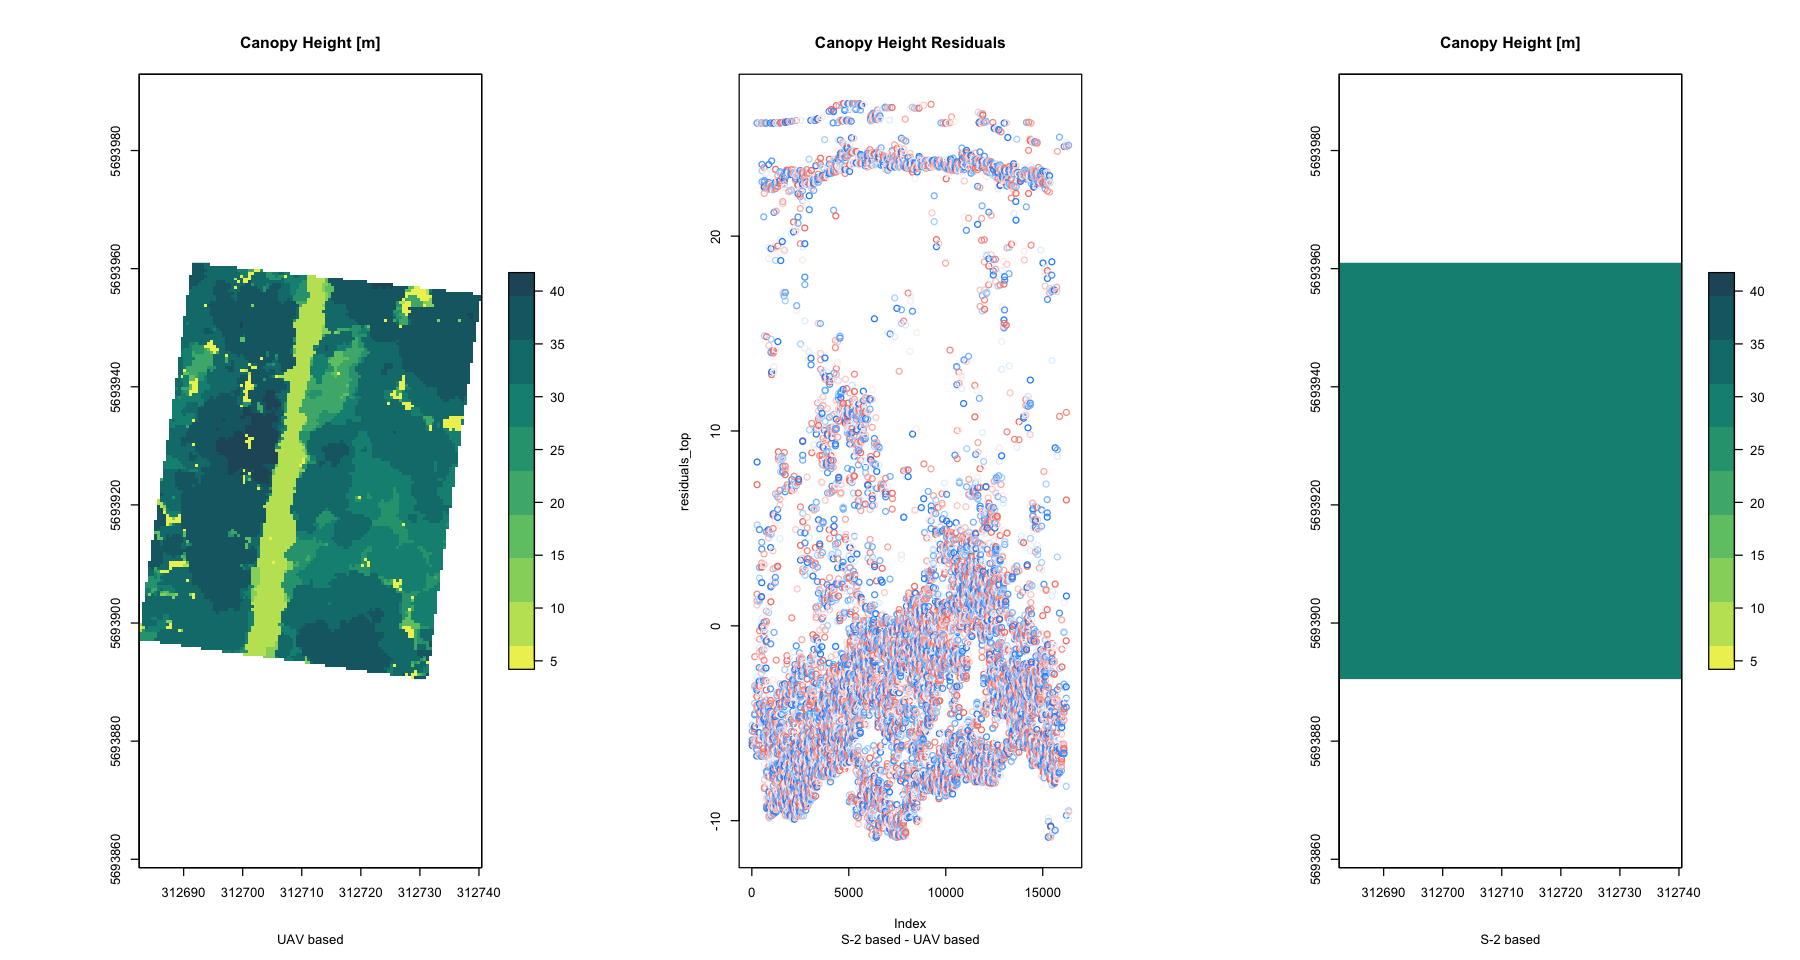

In [79]:
# Define common color palette
common_range <- range(c(values(h_uav_top_res), values(h_s2_top)), na.rm = TRUE)
col_pal <- rev(carto_pal(10, "ag_GrnYl"))
col_pal_residuals <- colorRampPalette(c("dodgerblue", "white", "salmon"))(10)

# Plotting Canopy Height Maps and Residuals
par(mfrow = c(1, 3))

# Plot UAV based canopy height
plot(h_uav_top_res, col = col_pal, zlim = common_range, main = "Canopy Height [m]", sub = "UAV based", legend.width = 2)

# Plot Residuals (S-2 based - UAV based)
plot(residuals_top, col = col_pal_residuals, main = "Canopy Height Residuals", sub = "S-2 based - UAV based", legend.width = 2)

# Plot S-2 based canopy height
plot(h_s2_top, col = col_pal, zlim = common_range, main = "Canopy Height [m]", sub = "S-2 based", legend.width = 2)

Warning message in plot.window(...):
“"legend.width" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"legend.width" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"legend.width" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"legend.width" is not a graphical parameter”
Warning message in box(...):
“"legend.width" is not a graphical parameter”
Warning message in title(...):
“"legend.width" is not a graphical parameter”


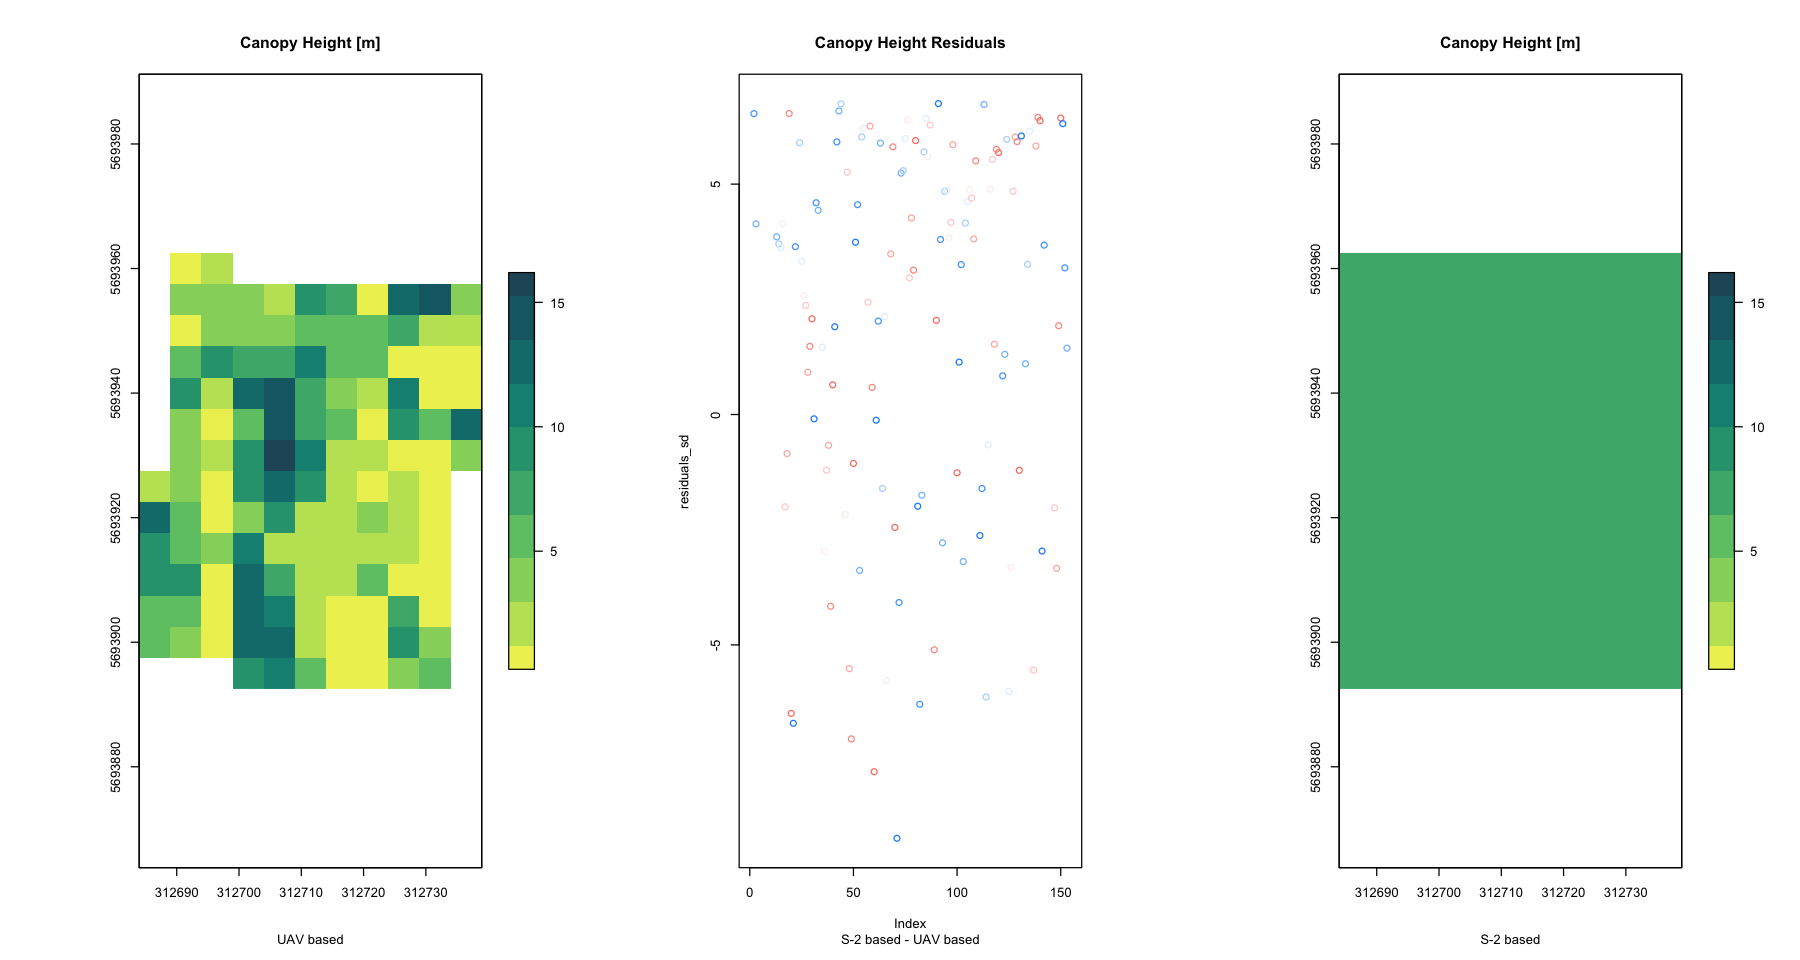

In [80]:
# Define common color palette
common_range <- range(c(values(h_uav_sd_res), values(h_s2_sd)), na.rm = TRUE)
col_pal <- rev(carto_pal(10, "ag_GrnYl"))
col_pal_residuals <- colorRampPalette(c("dodgerblue", "white", "salmon"))(10)

# Plotting Canopy Height Maps and Residuals
par(mfrow = c(1, 3))

# Plot UAV based canopy height
plot(h_uav_sd_res, col = col_pal, zlim = common_range, main = "Canopy Height [m]", sub = "UAV based", legend.width = 2)

# Plot Residuals (S-2 based - UAV based)
plot(residuals_sd, col = col_pal_residuals, main = "Canopy Height Residuals", sub = "S-2 based - UAV based", legend.width = 2)

# Plot S-2 based canopy height
plot(h_s2_sd, col = col_pal, zlim = common_range, main = "Canopy Height [m]", sub = "S-2 based", legend.width = 2)

**Quantative analysis**

In [81]:
h_uav_top_res

class      : RasterLayer 
dimensions : 141, 116, 16356  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : 312682.5, 312740.5, 5693890, 5693961  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : cloudcompare_dsm_v2 
values     : 4.199142, 41.74994  (min, max)


In [82]:
h_s2_top

class      : RasterLayer 
dimensions : 141, 116, 16356  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : 312682.5, 312740.5, 5693890, 5693961  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : ETH_GlobalCanopyHeight_DE_CHM_clip 
values     : 27.31782, 31  (min, max)


[1] "Mean of h_uav_top_res:  30.4951580849559"
[1] "Mean of h_s2_top:  30.2039276916002"
[1] "Correlation coefficient:  -0.104053466104899"


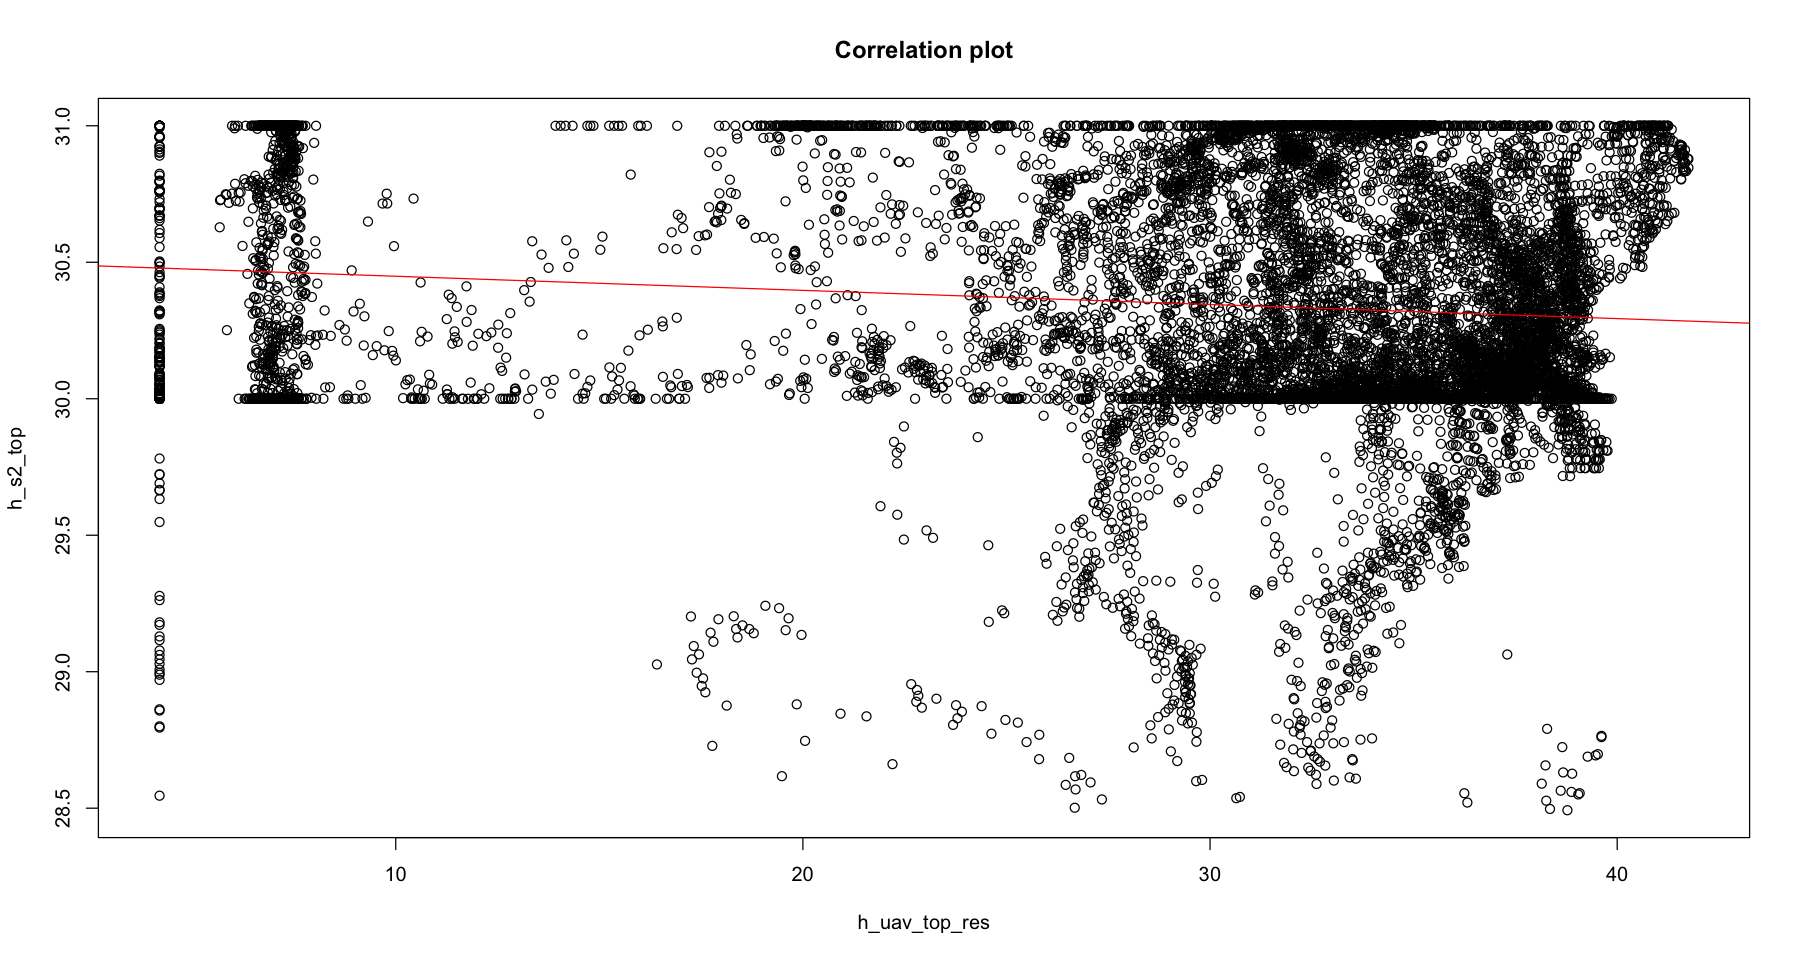

In [85]:
mean_h_uav_top_res <- cellStats(h_uav_top_res, stat='mean', na.rm=TRUE)
mean_h_s2_top <- cellStats(h_s2_top, stat='mean', na.rm=TRUE)

# Print the means
print(paste("Mean of h_uav_top_res: ", mean_h_uav_top_res))
print(paste("Mean of h_s2_top: ", mean_h_s2_top))

# Extract the values from the raster layers
values_h_uav_top_res <- getValues(h_uav_top_res)
values_h_s2_top <- getValues(h_s2_top)

# Remove NA values for correlation
valid_indices <- which(!is.na(values_h_uav_top_res) & !is.na(values_h_s2_top))
valid_values_h_uav_top_res <- values_h_uav_top_res[valid_indices]
valid_values_h_s2_top <- values_h_s2_top[valid_indices]

# Plot the correlation
plot(valid_values_h_uav_top_res, valid_values_h_s2_top, xlab="h_uav_top_res", ylab="h_s2_top", main="Correlation plot")
abline(lm(valid_values_h_s2_top ~ valid_values_h_uav_top_res), col="red")

# Calculate and print the correlation coefficient
correlation_coefficient <- cor(valid_values_h_uav_top_res, valid_values_h_s2_top)
print(paste("Correlation coefficient: ", correlation_coefficient))
